Epoch 1/300


/Users/sebastiancondyles/IdeaProjects/AdvAlgoHW4_1/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.7592 - root_mean_squared_error: 1.3082 - val_loss: 3.8786 - val_root_mean_squared_error: 1.9694
Epoch 2/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4741 - root_mean_squared_error: 0.6884 - val_loss: 1.9989 - val_root_mean_squared_error: 1.4138
Epoch 3/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3432 - root_mean_squared_error: 0.5857 - val_loss: 0.7337 - val_root_mean_squared_error: 0.8565
Epoch 4/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2789 - root_mean_squared_error: 0.5280 - val_loss: 0.3722 - val_root_mean_squared_error: 0.6101
Epoch 5/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2282 - root_mean_squared_error: 0.4776 - val_loss: 0.1927 - val_root_mean_squared_error: 0.4390
Epoch 6/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2145 - root_mean_squared_error: 0.4630 - val_loss: 0.1282 - val_root_mean_squared_error: 0.3580
Epoch 7/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1928 - ro

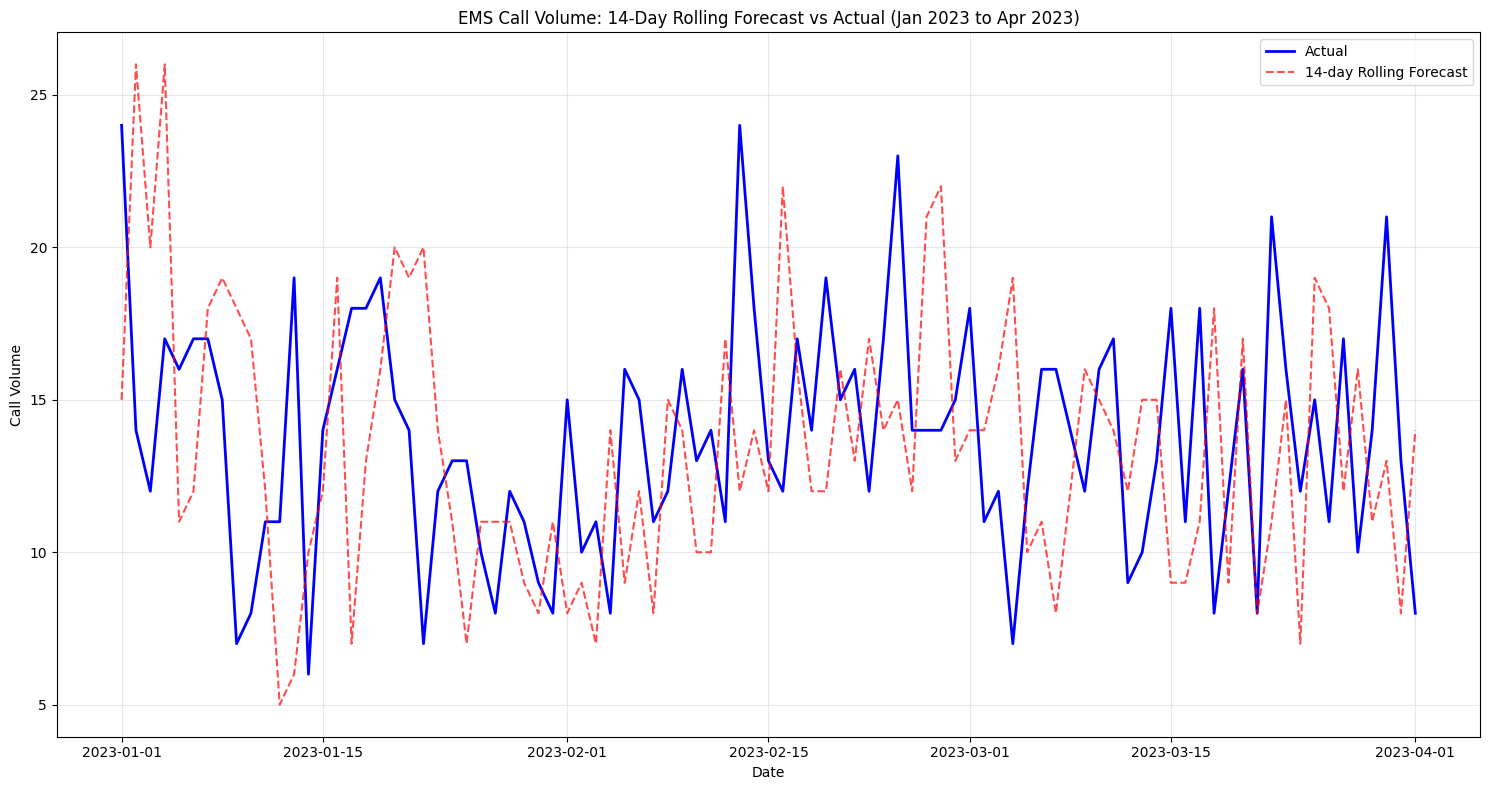

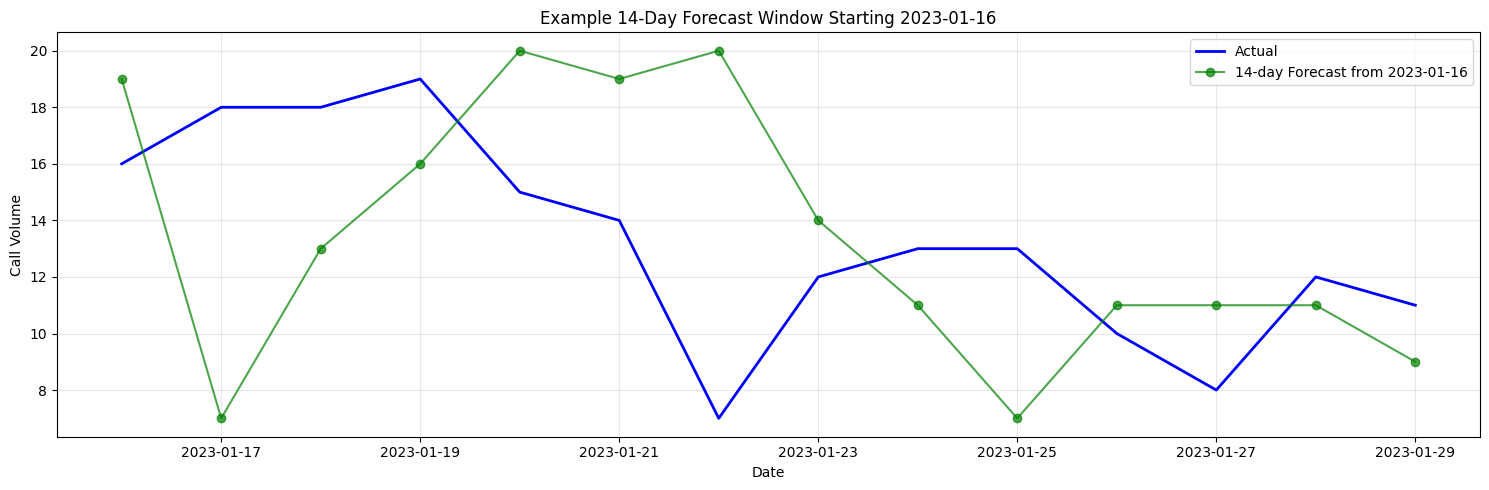


Forecast Accuracy by Horizon:
Horizon (Days) | RMSE | MAPE (%)
--------------------------------
            1 | 6.43 | 37.59%
            2 | 6.42 | 37.52%
            3 | 6.42 | 37.48%
            4 | 6.41 | 37.46%
            5 | 6.42 | 37.47%
            6 | 6.42 | 37.48%
            7 | 6.42 | 37.52%
            8 | 6.42 | 37.54%
            9 | 6.42 | 37.37%
           10 | 6.41 | 37.27%
           11 | 6.42 | 37.31%
           12 | 6.42 | 37.28%
           13 | 6.40 | 37.24%
           14 | 6.41 | 37.20%


In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from pandas.tseries.holiday import USFederalHolidayCalendar
import matplotlib.pyplot as plt

# --- 1. Load EMS Data ---
df = pd.read_csv("../data/clean/calls_full.csv")
df['CallDateTime'] = pd.to_datetime(df['CallDateTime'])
df = df[(df['CallDateTime'] >= '2017-01-01') & (df['CallDateTime'] < '2025-01-01')]
df['date'] = df['CallDateTime'].dt.date
daily = df.groupby('date').size().reset_index(name='call_volume')
daily['date'] = pd.to_datetime(daily['date'])

# --- 2. Calendar Features ---
daily['day_of_week'] = daily['date'].dt.dayofweek
daily['week_of_year'] = daily['date'].dt.isocalendar().week.astype(int)
daily['month'] = daily['date'].dt.month
daily['year'] = daily['date'].dt.year
daily['day_of_year'] = daily['date'].dt.dayofyear
daily['sin_doy'] = np.sin(2 * np.pi * daily['day_of_year'] / 365.25)
daily['cos_doy'] = np.cos(2 * np.pi * daily['day_of_year'] / 365.25)

# --- 3. Lag Features ---
for lag in [1, 2, 3, 7, 14]:
    daily[f'lag_{lag}'] = daily['call_volume'].shift(lag)

daily['rolling_3d'] = daily['call_volume'].rolling(3).mean()
daily['rolling_7d'] = daily['call_volume'].rolling(7).mean()
daily['rolling_30d'] = daily['call_volume'].rolling(30).mean()
daily['same_day_last_week'] = daily['call_volume'].shift(7)
daily['trend_3d'] = daily['rolling_3d'] - daily['rolling_7d']

# --- 4. Holiday/Weekend Flags ---
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays(start=daily['date'].min(), end=daily['date'].max())
daily['is_holiday'] = daily['date'].isin(holidays).astype(int)
daily['is_weekend'] = daily['day_of_week'].isin([5, 6]).astype(int)

# --- 5. Drop missing values for training only ---
train_data = daily[daily['date'] < '2023-01-01'].copy()
train_data.dropna(inplace=True)

# --- 6. Define Features ---
features = [
    'day_of_week', 'week_of_year', 'month', 'year',
    'lag_1', 'lag_2', 'lag_3', 'lag_7', 'lag_14',
    'rolling_3d', 'rolling_7d', 'rolling_30d',
    'same_day_last_week', 'trend_3d',
    'is_holiday', 'is_weekend',
    'sin_doy', 'cos_doy'
]

# --- 7. Train/Evaluation Data ---
X_train = train_data[features]
y_train = train_data['call_volume']

# --- 8. Scale Inputs ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# --- 9. Log-transform targets for training ---
y_train_log = np.log1p(y_train)

# --- 10. Build Keras MLP Model ---
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

# --- 11. Train with Early Stopping ---
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

model.fit(
    X_train_scaled, y_train_log,
    validation_split=0.1,
    epochs=300,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# --- 12. Function to generate features for a given dataframe ---
def generate_features(df, target_row_only=False):
    """Generate time series features from date column

    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe with date and call_volume columns
    target_row_only : bool, default=False
        If True, only generate features for the last row in the dataframe
        This is useful for performance when forecasting

    Returns:
    --------
    pandas.DataFrame with features added
    """
    result = df.copy()

    # Calendar features (these don't depend on previous data)
    result['day_of_week'] = result['date'].dt.dayofweek
    result['week_of_year'] = result['date'].dt.isocalendar().week.astype(int)
    result['month'] = result['date'].dt.month
    result['year'] = result['date'].dt.year
    result['day_of_year'] = result['date'].dt.dayofyear
    result['sin_doy'] = np.sin(2 * np.pi * result['day_of_year'] / 365.25)
    result['cos_doy'] = np.cos(2 * np.pi * result['day_of_year'] / 365.25)

    # Holiday/Weekend flags (these don't depend on previous data)
    calendar = USFederalHolidayCalendar()
    holidays = calendar.holidays(start=result['date'].min(), end=result['date'].max())
    result['is_holiday'] = result['date'].isin(holidays).astype(int)
    result['is_weekend'] = result['day_of_week'].isin([5, 6]).astype(int)

    # Process only the target row if specified
    if target_row_only and len(result) > 1:
        target_date = result.iloc[-1]['date']
        historical_data = result.iloc[:-1].copy()
        target_row = result.iloc[[-1]].copy()

        # For lag features, we need to look up values directly
        for lag in [1, 2, 3, 7, 14]:
            lag_date = target_date - pd.Timedelta(days=lag)
            lag_value = historical_data.loc[historical_data['date'] == lag_date, 'call_volume']
            target_row[f'lag_{lag}'] = lag_value.iloc[0] if not lag_value.empty else np.nan

        # For rolling features, we need to calculate from historical data
        historical_dates = [target_date - pd.Timedelta(days=i) for i in range(1, 31)]

        # Get values for the rolling windows
        rolling_3d_values = [historical_data.loc[historical_data['date'] == d, 'call_volume'].iloc[0]
                             if not historical_data.loc[historical_data['date'] == d, 'call_volume'].empty
                             else np.nan for d in historical_dates[:3]]
        rolling_7d_values = [historical_data.loc[historical_data['date'] == d, 'call_volume'].iloc[0]
                             if not historical_data.loc[historical_data['date'] == d, 'call_volume'].empty
                             else np.nan for d in historical_dates[:7]]
        rolling_30d_values = [historical_data.loc[historical_data['date'] == d, 'call_volume'].iloc[0]
                              if not historical_data.loc[historical_data['date'] == d, 'call_volume'].empty
                              else np.nan for d in historical_dates[:30]]

        # Calculate rolling means
        target_row['rolling_3d'] = np.nanmean(rolling_3d_values) if not all(np.isnan(rolling_3d_values)) else np.nan
        target_row['rolling_7d'] = np.nanmean(rolling_7d_values) if not all(np.isnan(rolling_7d_values)) else np.nan
        target_row['rolling_30d'] = np.nanmean(rolling_30d_values) if not all(np.isnan(rolling_30d_values)) else np.nan

        # Same day last week
        last_week_date = target_date - pd.Timedelta(days=7)
        last_week_value = historical_data.loc[historical_data['date'] == last_week_date, 'call_volume']
        target_row['same_day_last_week'] = last_week_value.iloc[0] if not last_week_value.empty else np.nan

        # Calculate trend
        target_row['trend_3d'] = target_row['rolling_3d'] - target_row['rolling_7d']

        return target_row
    else:
        # For all rows, use the pandas functions as before
        # Lag features
        for lag in [1, 2, 3, 7, 14]:
            result[f'lag_{lag}'] = result['call_volume'].shift(lag)

        # Rolling features - use min_periods=1 to avoid NaNs
        result['rolling_3d'] = result['call_volume'].rolling(3, min_periods=1).mean()
        result['rolling_7d'] = result['call_volume'].rolling(7, min_periods=1).mean()
        result['rolling_30d'] = result['call_volume'].rolling(30, min_periods=1).mean()
        result['same_day_last_week'] = result['call_volume'].shift(7)

        # Calculate trend feature
        result['trend_3d'] = result['rolling_3d'] - result['rolling_7d']

        return result

# --- 13. Create a dataframe for the forecast period ---
last_train_date = train_data['date'].max()
test_start_date = pd.Timestamp('2023-01-01')
test_end_date = pd.Timestamp('2024-12-31')

# Get actual data for 2023-2024 for evaluation
actual_test_data = daily[(daily['date'] >= test_start_date) & (daily['date'] <= test_end_date)].copy()

# Create a new dataframe with all dates in the forecast period
date_range = pd.date_range(start=test_start_date, end=test_end_date)
forecast_df = pd.DataFrame({'date': date_range})
forecast_df['call_volume'] = np.nan  # Will be filled with predictions

# --- 14. Rolling 14-day forecast (FIXED) ---
# First, we need historical data to initialize our forecast
historical_window = daily[(daily['date'] <= last_train_date) &
                          (daily['date'] > last_train_date - pd.Timedelta(days=30))].copy()

# Combine historical data with forecast dataframe to create our working dataset
forecast_with_history = pd.concat([historical_window, forecast_df], ignore_index=True)
forecast_with_history.sort_values('date', inplace=True)
forecast_with_history['predicted_calls'] = np.nan
forecast_with_history['is_synthetic'] = False  # Flag to track which values are synthetic predictions

# Dictionary to store predictions by date for easy lookup
predictions_by_date = {}

# Perform rolling forecast
print("Starting 14-day rolling forecast...")
for i, forecast_date in enumerate(date_range):
    # Print progress every month
    if forecast_date.day == 1:
        print(f"Forecasting for {forecast_date.strftime('%Y-%m')}")

    # Get all data up to the day before forecast date
    historical_data = forecast_with_history[forecast_with_history['date'] < forecast_date].copy()

    # Use actual data for evaluation if available
    actual_for_date = actual_test_data[actual_test_data['date'] == forecast_date]
    if not actual_for_date.empty:
        actual_calls = actual_for_date['call_volume'].values[0]
        forecast_with_history.loc[forecast_with_history['date'] == forecast_date, 'call_volume'] = actual_calls
        forecast_with_history.loc[forecast_with_history['date'] == forecast_date, 'is_synthetic'] = False

    # For each day in the 14-day window, generate forecasts sequentially
    for day_offset in range(14):
        # Define target date for this prediction
        target_date = forecast_date + pd.Timedelta(days=day_offset)

        # Skip if we're beyond our forecast period
        if target_date > test_end_date:
            continue

        # For the very first prediction (day_offset=0), we use only historical data
        if day_offset == 0:
            # Create a dataframe containing the target row + all historical data
            target_data = pd.DataFrame({'date': [target_date], 'call_volume': [np.nan]})
            combined_data = pd.concat([historical_data, target_data], ignore_index=True)
            combined_data.sort_values('date', inplace=True)

            # Generate features for the target row only (more efficient)
            target_row = generate_features(combined_data, target_row_only=True)
        else:
            # For later days, we include previous predictions in this forecast window
            previous_dates = [forecast_date + pd.Timedelta(days=d) for d in range(day_offset)]
            previous_predictions = forecast_with_history[forecast_with_history['date'].isin(previous_dates)].copy()

            # Combine historical data with previous predictions
            combined_data = pd.concat([historical_data, previous_predictions], ignore_index=True)
            # Add the target date row
            target_data = pd.DataFrame({'date': [target_date], 'call_volume': [np.nan]})
            combined_data = pd.concat([combined_data, target_data], ignore_index=True)
            combined_data.sort_values('date', inplace=True)

            # Generate features for the target row only (more efficient)
            target_row = generate_features(combined_data, target_row_only=True)

        # Skip if we're missing any required features after our best effort
        if target_row[features].isna().any().any():
            # Instead of skipping, let's fill missing values with reasonable defaults
            for feature in features:
                if target_row[feature].isna().any():
                    if feature.startswith('lag_') or feature == 'same_day_last_week':
                        # For lag features, use the mean of available lags
                        lag_cols = [col for col in target_row.columns if col.startswith('lag_') and not target_row[col].isna().any()]
                        if lag_cols:
                            target_row[feature] = target_row[lag_cols].mean(axis=1)
                        else:
                            # Fallback to global mean from training data
                            target_row[feature] = train_data['call_volume'].mean()
                    elif feature.startswith('rolling_'):
                        # For rolling features, use other available rolling averages, or the most recent value
                        roll_cols = [col for col in target_row.columns if col.startswith('rolling_') and not target_row[col].isna().any()]
                        if roll_cols:
                            target_row[feature] = target_row[roll_cols].mean(axis=1)
                        elif 'lag_1' in target_row and not target_row['lag_1'].isna().any():
                            target_row[feature] = target_row['lag_1']
                        else:
                            # Fallback to global mean
                            target_row[feature] = train_data['call_volume'].mean()
                    elif feature == 'trend_3d':
                        # For trend, use 0 (no trend) if missing
                        target_row[feature] = 0

        # Scale features
        X_pred = target_row[features]
        X_pred_scaled = scaler.transform(X_pred)

        # Make prediction
        pred_log = model.predict(X_pred_scaled, verbose=0).flatten()[0]

        # Add safety checks to handle potential numerical issues
        # Calculate reasonable bounds based on historical data
        mean_calls = train_data['call_volume'].mean()
        std_calls = train_data['call_volume'].std()
        min_calls = max(1, mean_calls - 3 * std_calls)  # At least 1 call
        max_calls = mean_calls + 3 * std_calls  # 3 standard deviations above mean

        # Convert log prediction to calls with bounds
        try:
            pred_calls_raw = np.expm1(pred_log)
            # Apply bounds - ensure prediction is within reasonable range
            pred_calls = int(np.clip(pred_calls_raw, min_calls, max_calls).round())
        except (OverflowError, ValueError):
            # If numerical error occurs, use mean prediction
            print(f"Warning: Numerical issue with prediction for {target_date}, using bounded value.")
            pred_calls = int(mean_calls)
        if day_offset == 0:
            predictions_by_date[target_date] = pred_calls

        # Update forecast dataframe with prediction
        forecast_with_history.loc[forecast_with_history['date'] == target_date, 'predicted_calls'] = pred_calls

        # Only update call_volume if we don't have actual data (i.e., it's a true forecast)
        if forecast_with_history.loc[forecast_with_history['date'] == target_date, 'call_volume'].isna().any():
            forecast_with_history.loc[forecast_with_history['date'] == target_date, 'call_volume'] = pred_calls
            forecast_with_history.loc[forecast_with_history['date'] == target_date, 'is_synthetic'] = True

        # After making this prediction, update historical_data to include it for next predictions
        if day_offset == 0:
            # For first prediction, add to historical data for subsequent predictions in this window
            new_data = forecast_with_history[forecast_with_history['date'] == target_date].copy()
            historical_data = pd.concat([historical_data, new_data], ignore_index=True)

# --- 15. Evaluate 1-day ahead predictions only (comparing with actual values) ---
# Extract predictions from our stored dictionary
day1_predictions = []
day1_actuals = []

for date in actual_test_data['date']:
    if date in predictions_by_date:
        day1_predictions.append(predictions_by_date[date])
        day1_actuals.append(actual_test_data.loc[actual_test_data['date'] == date, 'call_volume'].values[0])

if day1_predictions:
    day1_rmse = np.sqrt(mean_squared_error(day1_actuals, day1_predictions))
    day1_mape = np.mean(np.abs((np.array(day1_actuals) - np.array(day1_predictions)) / np.array(day1_actuals))) * 100
    print(f"\nDay 1 Forecast RMSE: {day1_rmse:.2f}")
    print(f"Day 1 Forecast MAPE: {day1_mape:.2f}%")

# --- 16. Plot results ---
# Filter to actual test period and get necessary columns
plot_df = forecast_with_history[forecast_with_history['date'] >= test_start_date].copy()
plot_df = plot_df[['date', 'call_volume', 'predicted_calls', 'is_synthetic']]

# Merge with actuals for comparison
plot_df = pd.merge(plot_df, actual_test_data[['date', 'call_volume']],
                   on='date', how='left', suffixes=('_pred', '_actual'))

# Create plot
plt.figure(figsize=(15, 8))

# Sample a few months to make the plot clearer
sample_months = 3
sample_start = test_start_date
sample_end = sample_start + pd.Timedelta(days=30*sample_months)

# Filter data for sample period
sample_df = plot_df[(plot_df['date'] >= sample_start) & (plot_df['date'] <= sample_end)]

# Plot actual values
plt.plot(sample_df['date'], sample_df['call_volume_actual'],
         label='Actual', color='blue', linewidth=2)

# Plot predictions
plt.plot(sample_df['date'], sample_df['predicted_calls'],
         label='14-day Rolling Forecast', color='red', linestyle='--', alpha=0.7)

# Formatting
plt.title(f'EMS Call Volume: 14-Day Rolling Forecast vs Actual ({sample_start.strftime("%b %Y")} to {sample_end.strftime("%b %Y")})')
plt.xlabel('Date')
plt.ylabel('Call Volume')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Create a second plot showing the 14-day forecasts made from a specific day
# Select an example date in the middle of the sample period
forecast_example_date = sample_start + pd.Timedelta(days=15)
forecast_window = pd.date_range(start=forecast_example_date, periods=14)

# Find the forecasts made for this window
forecast_window_df = forecast_with_history[forecast_with_history['date'].isin(forecast_window)].copy()

plt.figure(figsize=(15, 5))
plt.plot(actual_test_data[actual_test_data['date'].isin(forecast_window)]['date'],
         actual_test_data[actual_test_data['date'].isin(forecast_window)]['call_volume'],
         label='Actual', color='blue', linewidth=2)

plt.plot(forecast_window_df['date'], forecast_window_df['predicted_calls'],
         label=f'14-day Forecast from {forecast_example_date.strftime("%Y-%m-%d")}',
         color='green', marker='o', linestyle='-', alpha=0.7)

plt.title(f'Example 14-Day Forecast Window Starting {forecast_example_date.strftime("%Y-%m-%d")}')
plt.xlabel('Date')
plt.ylabel('Call Volume')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

# --- 17. Calculate accuracy metrics for different forecast horizons ---
horizon_metrics = {}

for horizon in range(1, 15):
    horizon_preds = []
    horizon_actuals = []

    # For each date in test data, find the prediction made exactly 'horizon' days before
    for date in actual_test_data['date']:
        forecast_date = date - pd.Timedelta(days=horizon)

        # Only include dates where we have both forecast and actual
        if forecast_date in date_range:
            # Get prediction from the main dataframe
            pred_row = forecast_with_history[
                (forecast_with_history['date'] == date) &
                (forecast_with_history['predicted_calls'].notna())
                ]

            if not pred_row.empty:
                horizon_preds.append(pred_row['predicted_calls'].values[0])
                horizon_actuals.append(actual_test_data.loc[actual_test_data['date'] == date, 'call_volume'].values[0])

    # Calculate metrics if we have predictions for this horizon
    if horizon_preds:
        rmse = np.sqrt(mean_squared_error(horizon_actuals, horizon_preds))
        mape = np.mean(np.abs((np.array(horizon_actuals) - np.array(horizon_preds)) / np.array(horizon_actuals))) * 100
        horizon_metrics[horizon] = {'rmse': rmse, 'mape': mape}

# Print metrics by horizon
print("\nForecast Accuracy by Horizon:")
print("Horizon (Days) | RMSE | MAPE (%)")
print("--------------------------------")
for horizon in range(1, 15):
    if horizon in horizon_metrics:
        print(f"{horizon:13d} | {horizon_metrics[horizon]['rmse']:.2f} | {horizon_metrics[horizon]['mape']:.2f}%")